1 Exploratory Data Analysis (EDA)
2 Feature Scaling
3 Multi-Output LSTM Model

### EDA

In [88]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [39]:
import os
print(os.getcwd())

c:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives


In [40]:
df = pd.read_csv("Data/gsod_station_722860.csv")

Checking NAs

In [41]:
# Show number of missing values per column
print(df.isna().sum())

# Or as a percentage of total
print(df.isna().mean() * 100)


Unnamed: 0    0
date          0
temp          0
max           0
min           0
dtype: int64
Unnamed: 0    0.0
date          0.0
temp          0.0
max           0.0
min           0.0
dtype: float64


In [42]:
temp_cols = ['temp', 'max', 'min']
print(df[temp_cols].isna().sum())


temp    0
max     0
min     0
dtype: int64


Checking Outliers

In [43]:
df['date'] = pd.to_datetime(df['date'])

In [45]:
max_outliers = df[df['max'] > 50]
print(max_outliers)

       Unnamed: 0       date   temp      max   min  year
13463       13463 1969-12-15   8.78  5537.72 -2.78  1969
14722       14722 1973-05-27  19.33  5537.72  7.72  1973
15607       15607 1975-10-29  16.56  5537.72  7.22  1975
28815       28815 2011-12-28   8.22  5537.72 -2.50  2011
28818       28818 2011-12-31  11.56  5537.72  1.72  2011
31007       31007 2017-12-28  11.44  5537.72  1.22  2017
32089       32089 2020-12-20   8.89  5537.72 -1.78  2020


In [46]:
min_outliers = df[df['min'] > 50]
print(min_outliers)

       Unnamed: 0       date   temp    max      min  year
7               7 1933-01-08  14.44  23.50  5537.72  1933
164           164 1933-06-14  33.17  38.89  5537.72  1933
12673       12673 1967-10-17  22.61  35.50  5537.72  1967
22929       22929 1995-11-15  11.83  23.78  5537.72  1995


Removing Outliers

In [ ]:
import numpy as np

# Replace outliers with NaN for MAX and MIN
threshold_max = 100   # adjust according to realistic limits for your dataset

df.loc[df['max'] > threshold_max, 'max'] = np.nan
df.loc[df['min'] > threshold_max, 'min'] = np.nan

# Optionally, interpolate missing values
df['max'] = df['max'].interpolate(method='linear')
df['min'] = df['min'].interpolate(method='linear')

# Check the stats to confirm values are now within a realistic range
print(df[['date', 'max', 'min']].describe())

                                date           max           min
count                          33651  33651.000000  33651.000000
mean   1979-02-25 22:18:40.085584320     25.608117      9.812687
min              1933-01-01 00:00:00      3.000000     -8.280000
25%              1956-02-16 12:00:00     20.000000      5.610000
50%              1979-02-28 00:00:00     25.500000     10.000000
75%              2002-03-12 12:00:00     31.720000     13.890000
max              2025-03-31 00:00:00     46.500000     34.110000
std                              NaN      7.414279      5.632309


Checking Average, Max, Min Temperature Trends Over the Years

           temp        max        min
year                                 
1933  20.335956  24.474238  12.261787
1934  21.830904  25.949918  13.858055
1935  20.128548  23.932411  12.612110
1936  17.528989  25.632623  10.377842
1937  16.304521  25.044137   9.338137
...         ...        ...        ...
2020  17.449317  28.068320   7.640164
2021  17.868956  27.377500   9.182555
2022  18.536164  27.958274  10.072438
2023  16.591973  25.499260   8.533973
2024  17.400109  27.087541   8.751421

[92 rows x 3 columns]


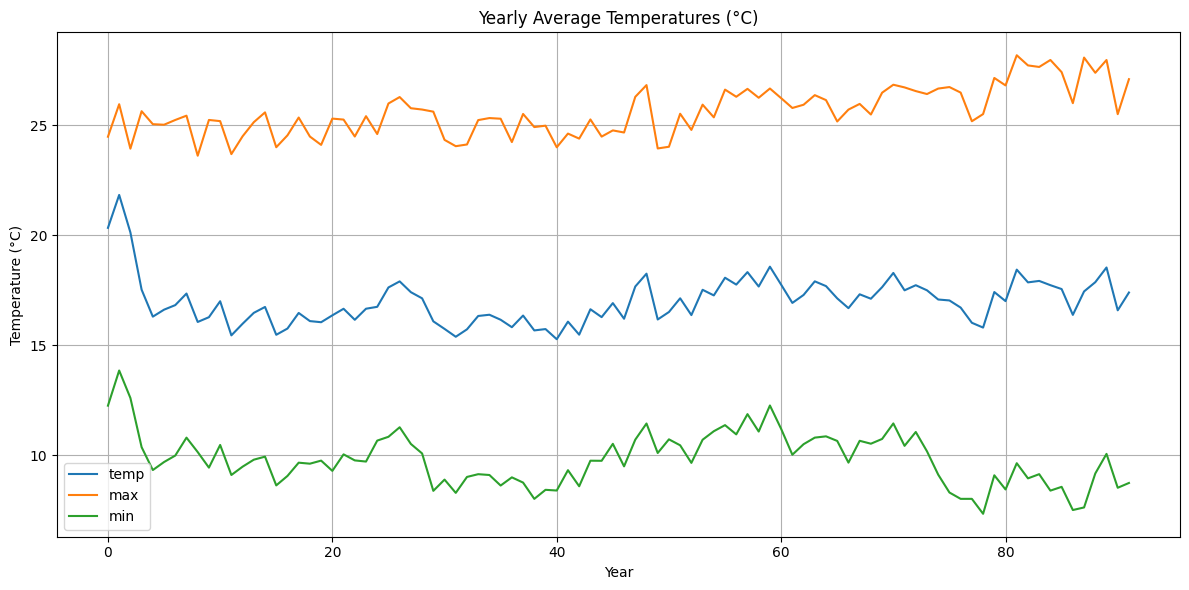

In [120]:
# Extract year for grouping
df['year'] = df['date'].dt.year

# Group by year and calculate mean
yearly_trends = df.groupby('year')[temp_cols].mean()
yearly_trends = yearly_trends[yearly_trends.index < 2025]
print(yearly_trends)
yearly_trends.reset_index(inplace=True)


plt.figure(figsize=(12, 6))
for col in temp_cols:
    plt.plot(yearly_trends.index, yearly_trends[col], label=col)

plt.title("Yearly Average Temperatures (°C)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Checking Difference Between Max and Min Temperature Over the Years

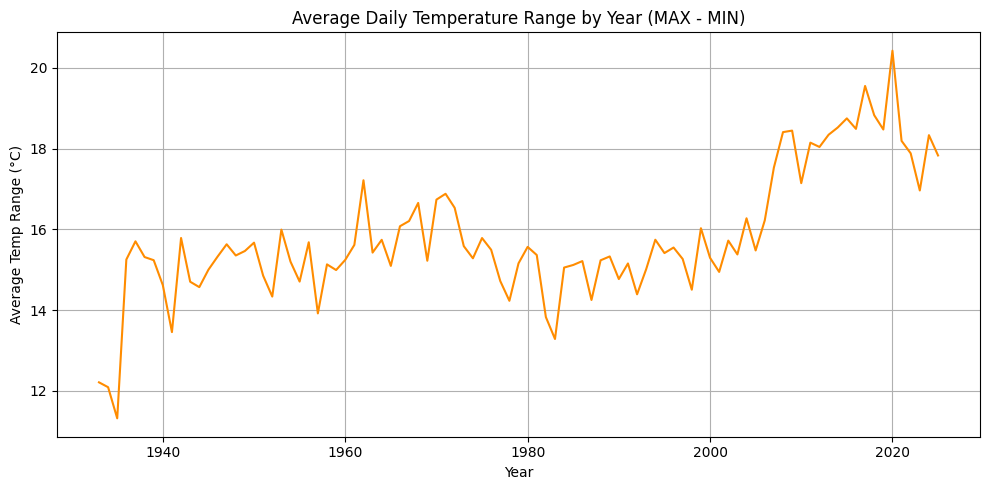

In [48]:
# Add a new column for the daily range
df['temp_range'] = df['max'] - df['min']

# Group by year and calculate average range
temp_range_by_year = df.groupby('year')['temp_range'].mean()

# Plot the average temp range
plt.figure(figsize=(10, 5))
plt.plot(temp_range_by_year.index, temp_range_by_year.values, color='darkorange')
plt.title("Average Daily Temperature Range by Year (MAX - MIN)")
plt.xlabel("Year")
plt.ylabel("Average Temp Range (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


year
1933    361
1934    365
1935    365
1936    366
1937    365
1938    365
1939    365
1940    366
1941    335
1942    365
1943    365
1944    366
1945    365
1946    365
1947    365
1948    366
1949    365
1950    365
1951    365
1952    366
1953    365
1954    365
1955    365
1956    366
1957    365
1958    365
1959    365
1960    366
1961    365
1962    365
1963    365
1964    366
1965    365
1966    365
1967    365
1968    366
1969    365
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1981    365
1982    365
1983    365
1984    366
1985    365
1986    365
1987    365
1988    366
1989    365
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    364
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365

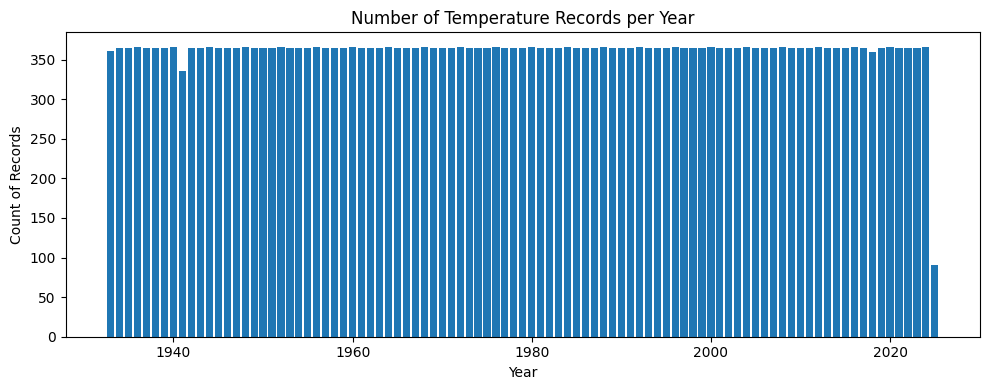

In [ ]:
# Count number of measurements per year
freq_by_year = df.groupby('year').size()
print(freq_by_year.to_string())

# Plot number of records per year
plt.figure(figsize=(10, 4))
plt.bar(freq_by_year.index, freq_by_year.values)
plt.title("Number of Temperature Records per Year")
plt.xlabel("Year")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()

### Feature Scaling

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = ['temp', 'max', 'min']
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[features] = scaler.fit_transform(df[features])

print("Scaled data summary:")
print(df_scaled[features].describe())



Scaled data summary:
               temp           max           min
count  33651.000000  33651.000000  33651.000000
mean       0.423742      0.519727      0.426815
std        0.149351      0.170443      0.132869
min        0.000000      0.000000      0.000000
25%        0.306928      0.390805      0.327672
50%        0.409157      0.517241      0.431234
75%        0.540940      0.660230      0.523001
max        1.000000      1.000000      1.000000


### Train-Test Split

In [124]:
# Create train and test sets for the selected features (without shuffling for time series)
df_train, df_test = train_test_split(df_scaled, test_size=0.2, shuffle=False)

print("Train dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)

Train dataset shape: (26920, 7)
Test dataset shape: (6731, 7)


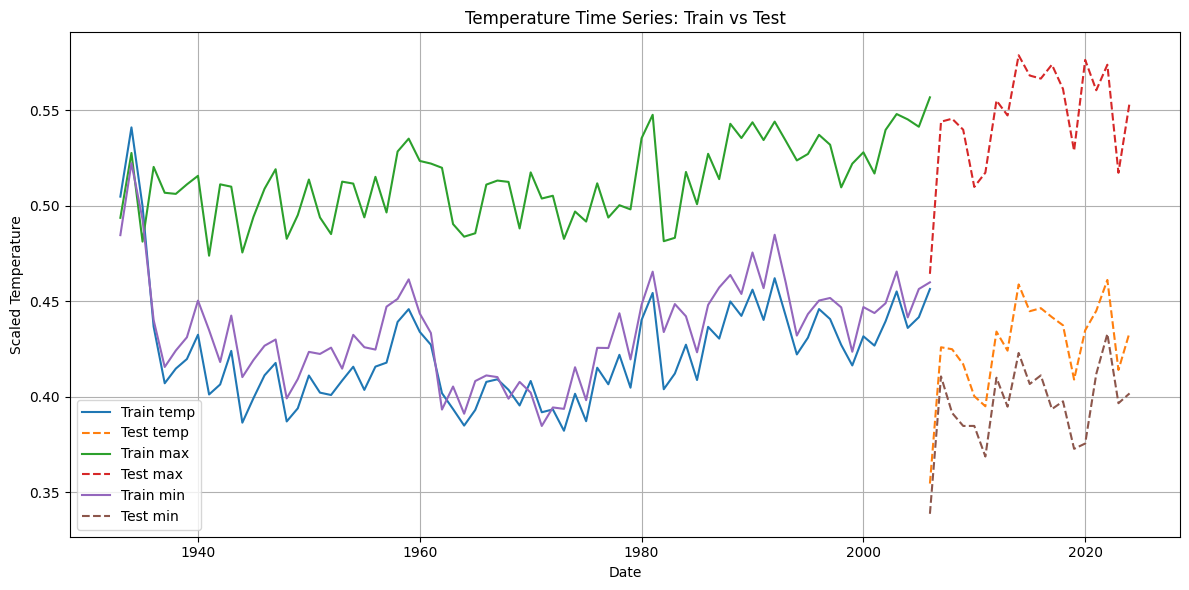

In [133]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

# Define temp_cols as the list of features.
temp_cols = ['temp', 'max', 'min']

# Group by year and calculate the mean.
yearly_trends_train = df_train.groupby('year')[temp_cols].mean()
yearly_trends_train = yearly_trends_train[yearly_trends_train.index < 2025]
yearly_trends_train.reset_index(inplace=False)

# Optionally, compute differences between consecutive years.
# yearly_trends_train['temp_diff'] = yearly_trends_train['temp'].diff()

yearly_trends_test = df_test.groupby('year')[temp_cols].mean()
yearly_trends_test = yearly_trends_test[yearly_trends_test.index < 2025]
yearly_trends_test.reset_index(inplace=False)

# yearly_trends_test['temp_diff'] = yearly_trends_test['temp'].diff()

plt.figure(figsize=(12, 6))
for col in temp_cols:
    # Plot training data (using the date column for the x-axis)
    plt.plot(yearly_trends_train.index, yearly_trends_train[col], label=f'Train {col}')
    # Plot testing data
    plt.plot(yearly_trends_test.index, yearly_trends_test[col], label=f'Test {col}', linestyle='--')

plt.title("Temperature Time Series: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM Training

HAVE TO TRULY COMPREHEND THE WINDOW SIZE

In [104]:
import numpy as np

def create_sequences(data, n_timesteps):
    """
    Converts time series data into sequences for LSTM training.
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - n_timesteps: number of past time steps to use in each input sequence.
    
    Returns:
    - X: numpy array of input sequences with shape (n_samples - n_timesteps, n_timesteps, n_features)
    - y: numpy array of outputs with shape (n_samples - n_timesteps, n_features)
    """
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i+n_timesteps])
        y.append(data[i+n_timesteps])
    return np.array(X), np.array(y)

data = df_train[['temp', 'max', 'min']].values

# Define the window size (e.g., using the previous 30 days)
n_timesteps = 30

X, y = create_sequences(data, n_timesteps)

print("Input shape X:", X.shape)   # Expected shape: (n_samples - n_timesteps, n_timesteps, 3)
print("Output shape y:", y.shape)  # Expected shape: (n_samples - n_timesteps, 3)


Input shape X: (26890, 30, 3)
Output shape y: (26890, 3)


In [105]:
import tensorflow as tf

# Custom learning rate schedule: lr = c / sqrt(t + 1)
class CSqrtSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, c):
        super().__init__()
        self.c = c  # The constant c

    def __call__(self, step):
        # Adding 1 to step to avoid division by zero (when t=0)
        return self.c / tf.sqrt(tf.cast(step + 1, tf.float32))
    
    def get_config(self):
        return {"c": self.c}


In [106]:
c_value = 0.1  # You can adjust this constant as needed
lr_schedule = CSqrtSchedule(c=c_value)
n_features = X.shape[2]  
n_outputs = y.shape[1]   
def create_model(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(n_timesteps, n_features)))
    # model.add(LSTM(50, return_sequences=True, input_shape=(n_timesteps, n_features)))
    model.add(LSTM(50))
    model.add(Dense(n_outputs, activation='elu'))
    model.compile(optimizer=AdamW(learning_rate=lr_schedule), loss='mse')
    return model

# Create the model instance and view the architecture
model = create_model(n_timesteps, n_features, n_outputs)
model.summary()

c:\Users\giamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 30, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,153 (121.69 KB)

 Trainable params: 31,153 (121.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set up the ModelCheckpoint callback to save the best model based on validation loss
checkpoint_cb = ModelCheckpoint("best_model.keras", 
                                save_best_only=True, 
                                monitor="val_loss", 
                                mode="min", 
                                verbose=1)

early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Train the model, including the ModelCheckpoint and EarlyStopping callbacks
history = model.fit(X, y, 
                    epochs=30, 
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9718
Epoch 1: val_loss improved from inf to 0.01836, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.9588 - val_loss: 0.0184
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0145
Epoch 2: val_loss improved from 0.01836 to 0.00571, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0144 - val_loss: 0.0057
Epoch 3/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0059
Epoch 3: val_loss improved from 0.00571 to 0.00439, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 4/20
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0047
Epoch 4: val_loss improved from 0.00439 to 0.00352, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040
Epoch 5: val_loss i

To improve:
- Increasing epochs
- Increasing layers
- Increasing batch size
- Changing activation function
- Increasing window span

### LSTM Testing

In [109]:
# For the test data, assume that df_test is already loaded and has the columns 'temp', 'max', 'min'.
# IMPORTANT: In practice, you should use the same scaler fitted on the training data.
# For this example, we demonstrate using a new scaler instance (fit on df_test), but ideally,
# you should do: df_test_scaled[features] = training_scaler.transform(df_test[features])

def create_test_sequences(data, n_timesteps):
    X_seq = []
    for i in range(len(data) - n_timesteps):
        X_seq.append(data[i:i+n_timesteps])
    return np.array(X_seq)

# Create test sequences.
X_test = create_test_sequences(df_test[features].values, n_timesteps)
print("Shape of X_test:", X_test.shape)


Shape of X_test: (6701, 30, 3)


- HAVE TO DO HYPERPARAMTER TUNING FOR THE BEST WEIGHTS DURING TRAINING (PROB BAYES.SEARCH)

In [116]:
# Generate predictions for the test sequences.
predictions_scaled = model.predict(X_test)

# Use the already fitted scaler to inverse transform the predictions.
predictions_original = scaler.inverse_transform(predictions_scaled)

# Convert predictions to a DataFrame for easier viewing.
predictions_df = pd.DataFrame(predictions_original, columns=features)
print("Predicted Temperatures (Original Scale):")
print(predictions_df)




210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Predicted Temperatures (Original Scale):
           temp        max        min
0     18.892429  28.829462  10.335796
1     20.418634  30.884565  11.145630
2     19.597151  29.380884  11.053599
3     16.670107  25.169073   9.799568
4     15.233056  23.410757   8.898345
...         ...        ...        ...
6696  13.112685  20.674103   7.102866
6697  12.200523  19.109547   6.908995
6698  10.682496  16.695583   6.149716
6699  13.992753  22.314302   7.015194
6700  12.240415  19.804943   6.113113

[6701 rows x 3 columns]
